<!-- 
 * @file        2_motion_sensor.ipynb
 * @brief       This notebook provides motion sensor data processing and analysis.
 * 
 * @authors     Jaehwan Lee (idljh5529@gmail.com)      
 *
 * @date        2025-08-11 Released by AI Lab, Hanyang University
 * 
-->

# 2. Vehicle Motion Sensor
이번 실습에서는 차량의 움직임을 출력하는 차량 모션 센서에 대해 학습합니다.

## 실습 목표
1. **IMU 데이터 분석**: 차량에 장착된 IMU 센서에서 수집한 데이터를 시각화하고 분석합니다.
2. **노이즈 필터링**: 센서 데이터에 포함된 노이즈를 제거하기 위한 다양한 필터링 기법을 학습합니다.
3. **Wheel Encoder 시뮬레이션**: 펄스 데이터를 생성하고 이를 통해 차량 속도를 추정하는 방법을 익힙니다.

## 다루는 차량 모션 센서 데이터
- **IMU (Inertial Measurement Unit)**: 각속도와 선형가속도 측정
- **Wheel Encoder**: 휠 회전을 통한 속도 측정

## 차량 모션 센서 실습 필요성

### 1. IMU 데이터 분석의 필요성
- **차량 동역학 이해**: IMU 데이터를 통해 차량의 실제 움직임(회전, 가속)을 정확히 파악
- **안전 시스템**: 급정거, 급회전 등 위험 상황 감지를 위한 기초 데이터
- **자율주행**: 차량의 자세 추정 및 경로 계획에 필수적인 정보

### 2. 노이즈 필터링의 중요성
- **센서 한계**: 모든 센서는 노이즈를 포함하므로 신호 처리가 필수
- **정확도 향상**: 필터링을 통해 실제 차량 움직임을 더 정확하게 추정
- **시스템 안정성**: 노이즈로 인한 오작동 방지

### 3. 휠 엔코더 활용
- **속도 측정**: GPS보다 높은 주파수로 정확한 속도 정보 획득
- **실시간 제어**: 차량 제어 시스템에서 즉각적인 피드백 제공
- **중복성**: 다른 센서와 함께 사용하여 시스템 신뢰성 증대

## 실습 시나리오
1. **급정거 시나리오**: 브레이킹 시 발생하는 선형가속도 변화 관찰
2. **원형 운동 시나리오**: 회전 시 발생하는 각속도 변화 분석
3. **추월 시나리오**: 차선 변경 시 복합적인 움직임 패턴 분석

In [1]:
# 외부에 정의된 파이썬 모듈(.py 파일)을 수정할 때마다 매번 커널을 재시작하지 않아도 변경 사항이 자동으로 반영되도록 설정
%load_ext autoreload
%autoreload 2

In [2]:
# 필요한 라이브러리 임포트
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 사용자 정의 모듈 임포트
sys.path.append('./tutlibs/motion_sensor')
from tutlibs.motion_sensor.custom_motion_sensor import MotionSensorProcessor

print("라이브러리 임포트 완료!")
print("Python 버전:", sys.version)
print("NumPy 버전:", np.__version__)
print("Matplotlib 버전:", plt.matplotlib.__version__)


라이브러리 임포트 완료!
Python 버전: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
NumPy 버전: 2.2.6
Matplotlib 버전: 3.10.5


## 1. ROS Bag 데이터 로딩 및 분석

실제 차량에서 수집한 ROS bag 데이터를 로드하고 기본적인 시각화를 수행하며 데이터를 분석합니다.
- `/gps/imu` 토픽: IMU 센서 데이터 (각속도, 선형가속도)
- `/novatel/oem7/inspvax` 토픽: GPS 위치 데이터 (위도, 경도)


In [3]:
# 모션 센서 처리 객체 생성
processor = MotionSensorProcessor()

# ROS bag 파일 경로 설정 (실제 파일이 없으면 시뮬레이션 데이터 사용)
bag_files = {
    'emergency_stop': './../data/imu/1_emergency_stop.bag',
    'circular_motion': './../data/imu/2_circular_motion.bag', 
    'overtaking': './../data/imu/3_overtaking.bag',
    'highway_inlet': './../data/imu/4_highway_inlet.bag',
}

# 로드할 토픽 정의
topics = ['/gps/imu', '/novatel/oem7/inspvax']

# 데이터 로딩 (여러 시나리오)
print("=== 차량 모션 센서 데이터 로딩 ===")
all_scenario_data = {}

for scenario, bag_path in bag_files.items():
    print(f"\n{scenario} 시나리오 데이터 로딩 중...")
    data = processor.load_rosbag_data(bag_path, topics)
    all_scenario_data[scenario] = data
    print(f"✓ {scenario} 데이터 로딩 완료")

print("\n모든 시나리오 데이터 로딩 완료!")


=== 차량 모션 센서 데이터 로딩 ===

emergency_stop 시나리오 데이터 로딩 중...
✓ emergency_stop 데이터 로딩 완료

circular_motion 시나리오 데이터 로딩 중...
✓ circular_motion 데이터 로딩 완료

overtaking 시나리오 데이터 로딩 중...
✓ overtaking 데이터 로딩 완료

highway_inlet 시나리오 데이터 로딩 중...
✓ highway_inlet 데이터 로딩 완료

모든 시나리오 데이터 로딩 완료!


각 시나리오 별로 차량 궤적과 IMU 데이터를 시각화하여 분석합니다.


=== 차량 궤적 시각화 ===

emergency_stop 시나리오 궤적 분석 중...


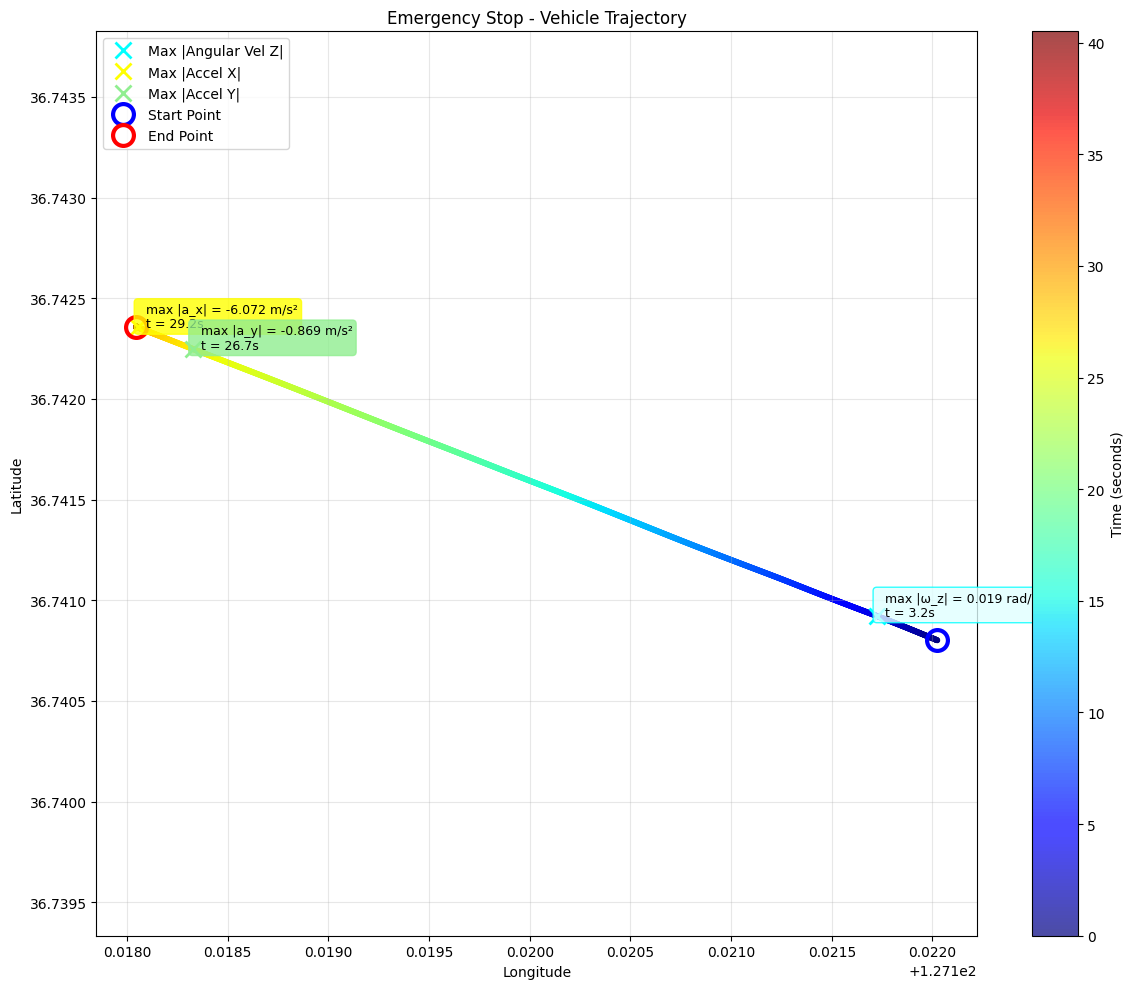

✓ emergency_stop 궤적 시각화 완료
  - 총 데이터 포인트: 4052개
  - 시간 범위: 40.5초
  - 최대 |각속도 Z|: 1.108 deg/s (값: 1.108)
  - 최대 |가속도 X|: 6.072 m/s² (값: -6.072)
  - 최대 |가속도 Y|: 0.869 m/s² (값: -0.869)

=== IMU 센서 데이터 분석 ===

emergency_stop 시나리오 IMU 분석 중...


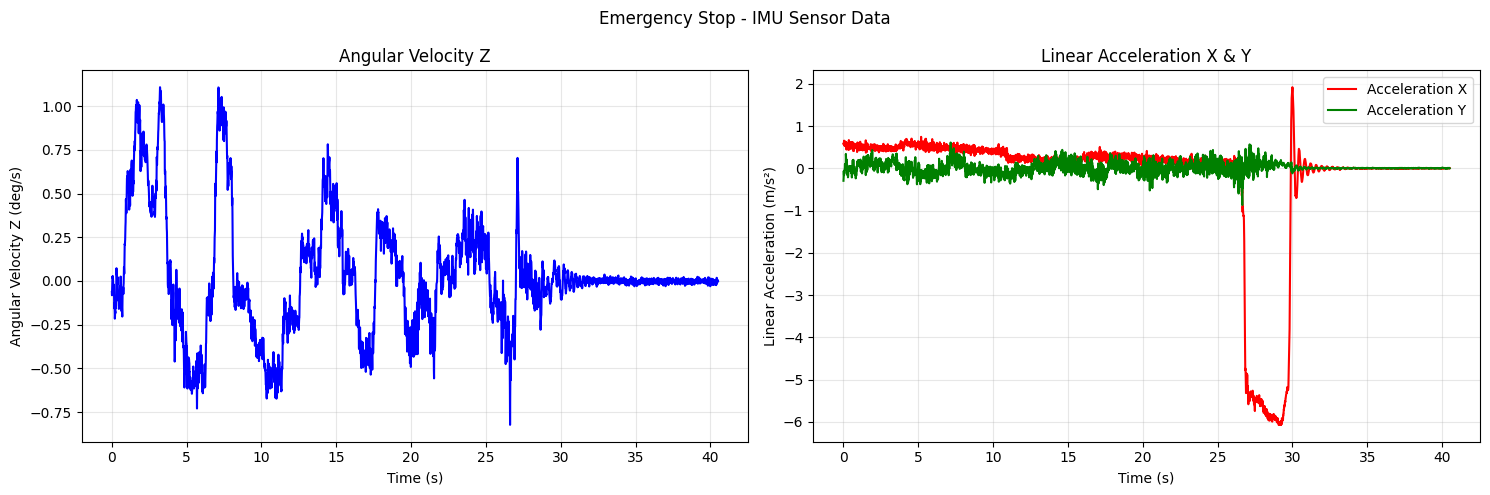

✓ emergency_stop IMU 시각화 완료
  - 각속도 Z 범위: -0.823 ~ 1.108 deg/s
  - 가속도 X 범위: -6.072 ~ 1.919 m/s²
  - 가속도 Y 범위: -0.869 ~ 0.610 m/s²

=== 차량 궤적 시각화 ===

circular_motion 시나리오 궤적 분석 중...


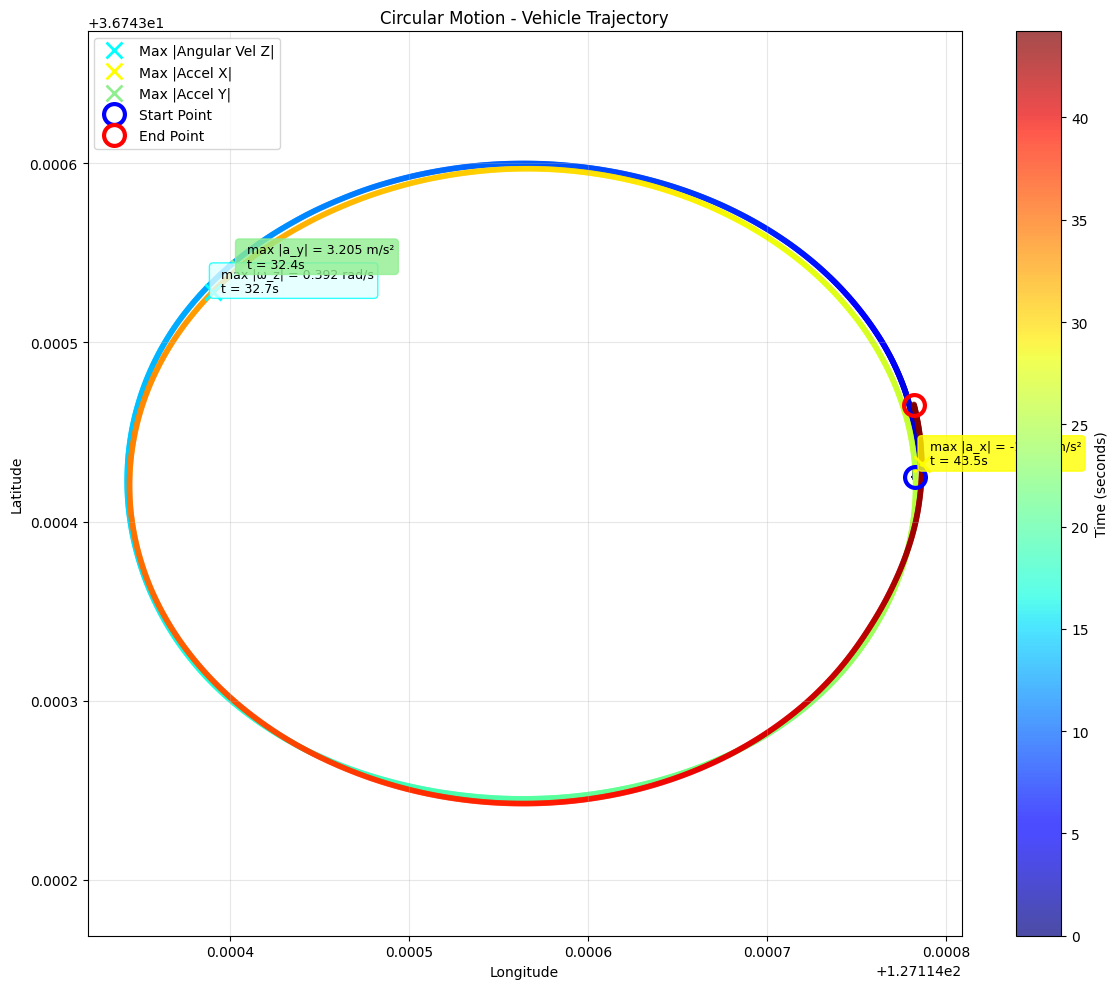

✓ circular_motion 궤적 시각화 완료
  - 총 데이터 포인트: 4422개
  - 시간 범위: 44.2초
  - 최대 |각속도 Z|: 22.451 deg/s (값: 22.451)
  - 최대 |가속도 X|: 1.362 m/s² (값: -1.362)
  - 최대 |가속도 Y|: 3.205 m/s² (값: 3.205)

=== IMU 센서 데이터 분석 ===

circular_motion 시나리오 IMU 분석 중...


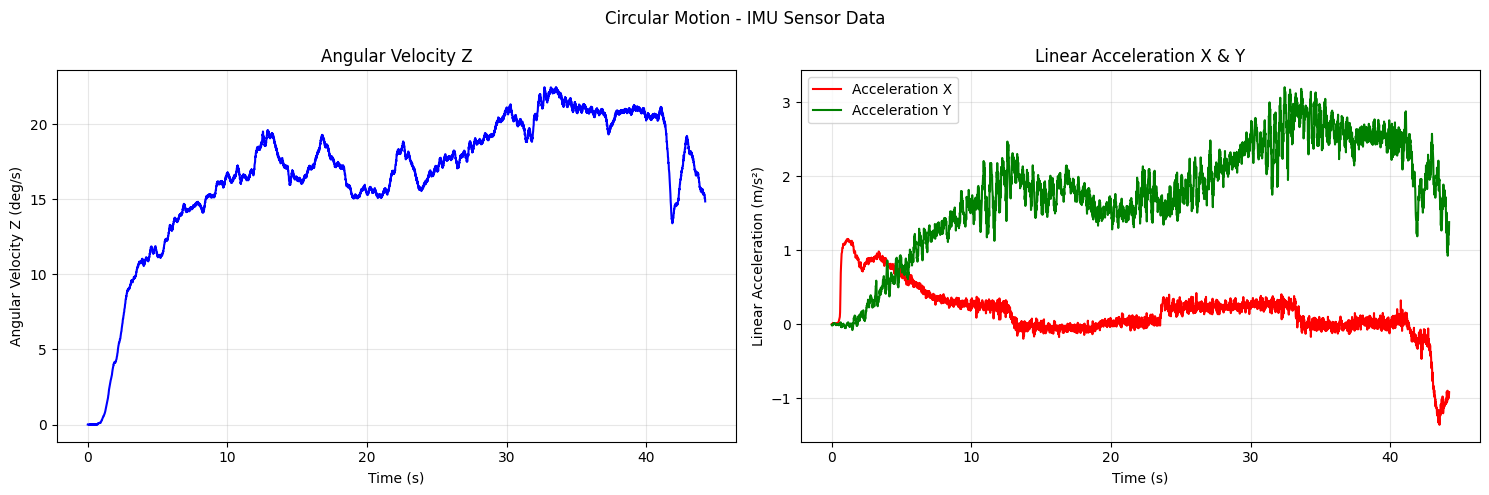

✓ circular_motion IMU 시각화 완료
  - 각속도 Z 범위: -0.020 ~ 22.451 deg/s
  - 가속도 X 범위: -1.362 ~ 1.153 m/s²
  - 가속도 Y 범위: -0.080 ~ 3.205 m/s²

=== 차량 궤적 시각화 ===

overtaking 시나리오 궤적 분석 중...


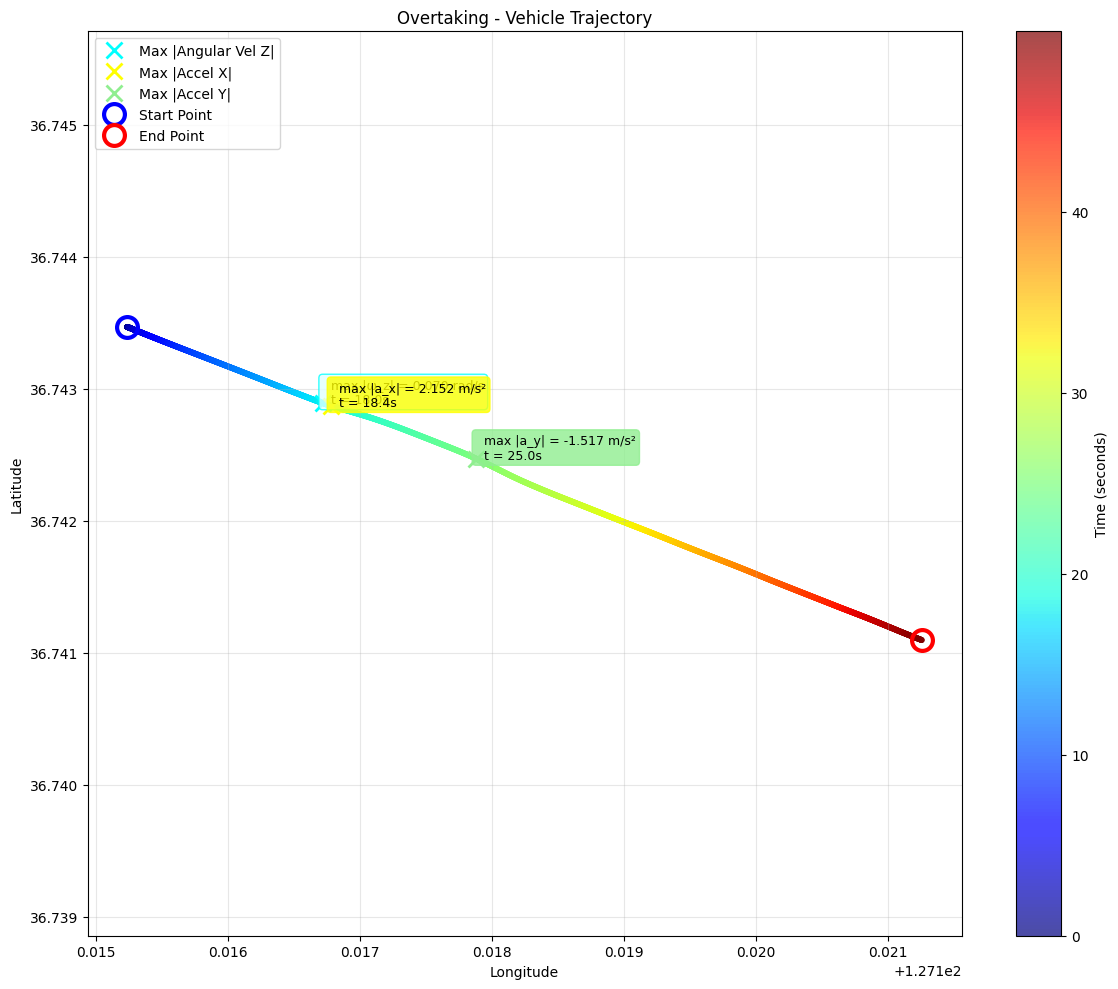

✓ overtaking 궤적 시각화 완료
  - 총 데이터 포인트: 4996개
  - 시간 범위: 50.0초
  - 최대 |각속도 Z|: 3.995 deg/s (값: 3.995)
  - 최대 |가속도 X|: 2.152 m/s² (값: 2.152)
  - 최대 |가속도 Y|: 1.517 m/s² (값: -1.517)

=== IMU 센서 데이터 분석 ===

overtaking 시나리오 IMU 분석 중...


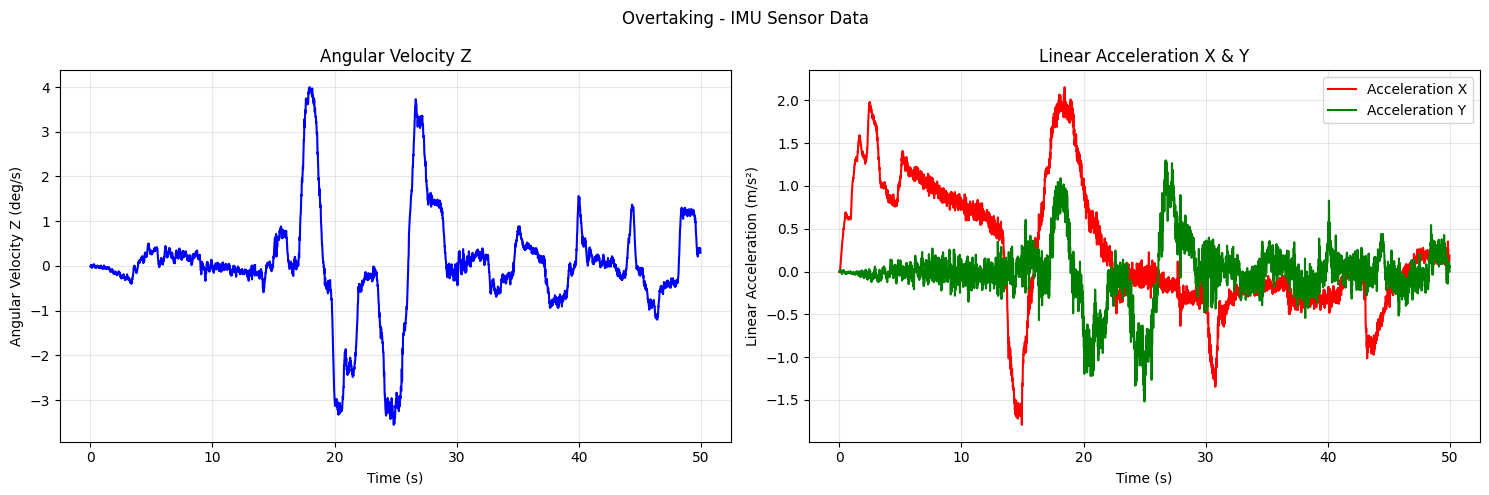

✓ overtaking IMU 시각화 완료
  - 각속도 Z 범위: -3.553 ~ 3.995 deg/s
  - 가속도 X 범위: -1.790 ~ 2.152 m/s²
  - 가속도 Y 범위: -1.517 ~ 1.297 m/s²

=== 차량 궤적 시각화 ===

highway_inlet 시나리오 궤적 분석 중...


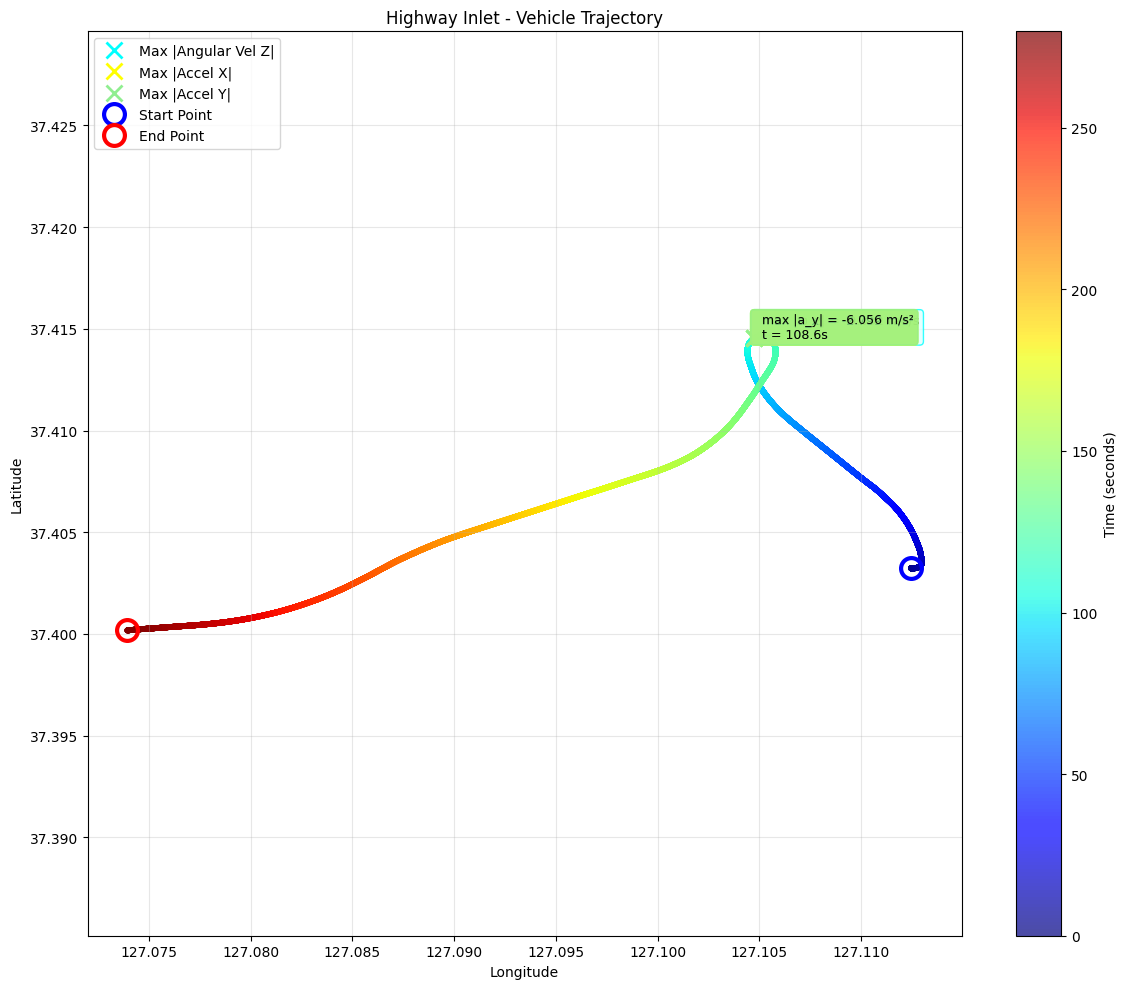

✓ highway_inlet 궤적 시각화 완료
  - 총 데이터 포인트: 27985개
  - 시간 범위: 279.8초
  - 최대 |각속도 Z|: 19.019 deg/s (값: -19.019)
  - 최대 |가속도 X|: 2.799 m/s² (값: -2.799)
  - 최대 |가속도 Y|: 6.056 m/s² (값: -6.056)

=== IMU 센서 데이터 분석 ===

highway_inlet 시나리오 IMU 분석 중...


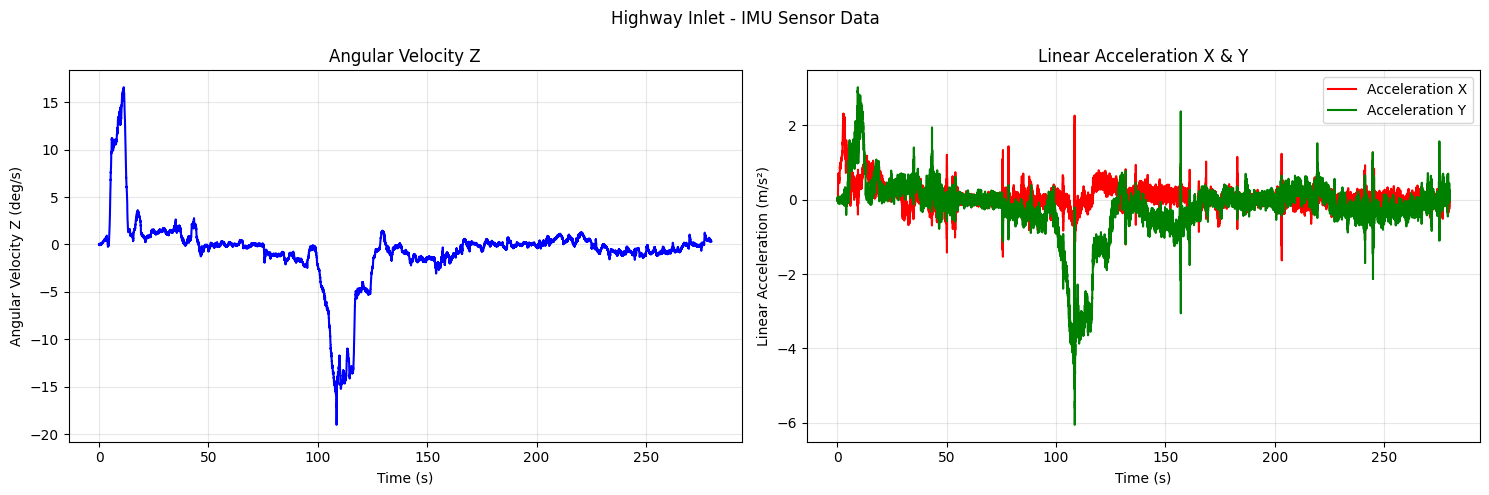

✓ highway_inlet IMU 시각화 완료
  - 각속도 Z 범위: -19.019 ~ 16.585 deg/s
  - 가속도 X 범위: -2.799 ~ 2.319 m/s²
  - 가속도 Y 범위: -6.056 ~ 3.028 m/s²


In [4]:
for scenario_name, scenario_data in all_scenario_data.items():
    # 시나리오별 차량 궤적 시각화
    print("\n=== 차량 궤적 시각화 ===")
    if '/novatel/oem7/inspvax' in scenario_data:
        print(f"\n{scenario_name} 시나리오 궤적 분석 중...")
        
        # GPS 데이터에서 위도, 경도, 시간 추출
        gps_data = scenario_data['/novatel/oem7/inspvax']
        latitudes, longitudes, times = processor.extract_gps_trajectory(gps_data)
        
        # IMU 데이터 추출 (최대값 표시를 위해)
        imu_data = None
        if '/gps/imu' in scenario_data:
            imu_raw_data = scenario_data['/gps/imu']
            imu_data = processor.extract_imu_data(imu_raw_data)
        
        # 궤적 시각화 (시간에 따른 색상 변화 + 최대값 지점 표시)
        processor.plot_trajectory_with_time(
            latitudes, longitudes, times, 
            title=f"{scenario_name.replace('_', ' ').title()} - Vehicle Trajectory",
            imu_data=imu_data
        )
        
        print(f"✓ {scenario_name} 궤적 시각화 완료")
        print(f"  - 총 데이터 포인트: {len(latitudes)}개")
        print(f"  - 시간 범위: {times[-1] - times[0]:.1f}초")
        
        if imu_data is not None:
            # 최대값 정보 출력
            angular_vel_z_deg = np.array(imu_data['angular_velocity_z']) * 180 / np.pi
            accel_x = np.array(imu_data['linear_acceleration_x'])
            accel_y = np.array(imu_data['linear_acceleration_y'])
            
            max_angular_value = angular_vel_z_deg[np.argmax(np.abs(angular_vel_z_deg))]
            max_accel_x_value = accel_x[np.argmax(np.abs(accel_x))]
            max_accel_y_value = accel_y[np.argmax(np.abs(accel_y))]
            
            print(f"  - 최대 |각속도 Z|: {np.max(np.abs(angular_vel_z_deg)):.3f} deg/s (값: {max_angular_value:.3f})")
            print(f"  - 최대 |가속도 X|: {np.max(np.abs(accel_x)):.3f} m/s² (값: {max_accel_x_value:.3f})")
            print(f"  - 최대 |가속도 Y|: {np.max(np.abs(accel_y)):.3f} m/s² (값: {max_accel_y_value:.3f})")
    
    # 시나리오별 IMU 데이터 분석
    print("\n=== IMU 센서 데이터 분석 ===")
    if '/gps/imu' in scenario_data:
        print(f"\n{scenario_name} 시나리오 IMU 분석 중...")
        
        # IMU 데이터 추출
        imu_raw_data = scenario_data['/gps/imu']
        imu_data = processor.extract_imu_data(imu_raw_data)
        
        # IMU 데이터 시각화
        processor.plot_imu_data(
            imu_data, 
            title=f"{scenario_name.replace('_', ' ').title()} - IMU Sensor Data"
        )
        
        print(f"✓ {scenario_name} IMU 시각화 완료")
        angular_vel_z_deg = np.asarray(imu_data['angular_velocity_z']) * 180 / np.pi
        print(f"  - 각속도 Z 범위: {np.min(angular_vel_z_deg):.3f} ~ {np.max(angular_vel_z_deg):.3f} deg/s")
        print(f"  - 가속도 X 범위: {np.min(imu_data['linear_acceleration_x']):.3f} ~ {np.max(imu_data['linear_acceleration_x']):.3f} m/s²")
        print(f"  - 가속도 Y 범위: {np.min(imu_data['linear_acceleration_y']):.3f} ~ {np.max(imu_data['linear_acceleration_y']):.3f} m/s²")


## 2. Noise Filtering 실습

센서 데이터에는 항상 노이즈가 포함되어 있습니다. 이를 제거하기 위한 다양한 필터링 기법을 학습합니다.

### 필터링 기법
1. **Average Filter**: 전체 데이터의 평균값으로 필터링
2. **Moving Average Filter**: 슬라이딩 윈도우를 사용한 이동 평균
3. **Exponential Moving Average Filter**: 가중 평균을 사용한 지수 이동 평균

### 실습 대상
- `/gps/imu/linear_acceleration/y` 데이터를 대상으로 필터링 실습을 진행합니다.


In [5]:
# 필터링 실습을 위한 데이터 선택
selected_scenario = 'overtaking'  # 오버테이킹 시나리오
imu_raw_data = all_scenario_data[selected_scenario]['/gps/imu']
imu_data = processor.extract_imu_data(imu_raw_data)

# 필터링 대상 데이터 추출
time_array = np.array(imu_data['time'])
time_relative = time_array - time_array[0]  # 상대 시간
angular_velocity_z_deg = np.array(imu_data['angular_velocity_z']) * 180 / np.pi
linear_acceleration_x = np.array(imu_data['linear_acceleration_x'])
linear_acceleration_y = np.array(imu_data['linear_acceleration_y'])

print(f"=== 노이즈 필터링 실습 ({selected_scenario}) ===")
print(f"원본 데이터 통계:")
print(f"  - 평균: {np.mean(linear_acceleration_y):.4f} m/s²")
print(f"  - 표준편차: {np.std(linear_acceleration_y):.4f} m/s²")
print(f"  - 데이터 포인트 수: {len(linear_acceleration_y)}개")

=== 노이즈 필터링 실습 (overtaking) ===
원본 데이터 통계:
  - 평균: -0.0136 m/s²
  - 표준편차: 0.3375 m/s²
  - 데이터 포인트 수: 4996개


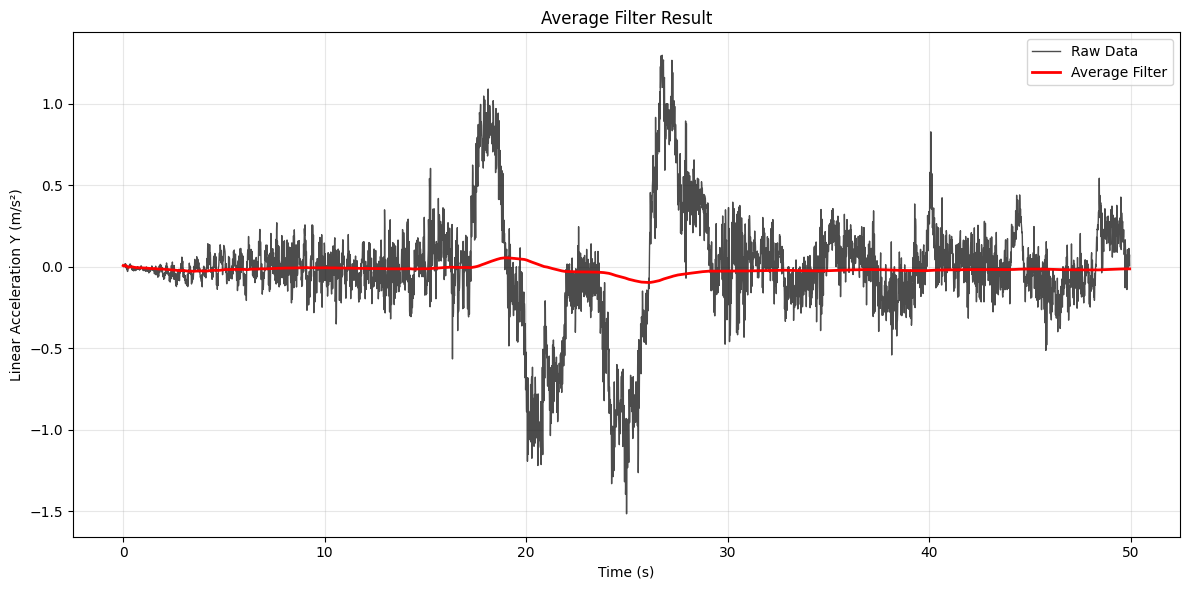

Average Filter 결과:
  - 평균: -0.0190 m/s²
  - 표준편차: 0.0225 m/s²
  - 노이즈 감소율: 93.3%


In [6]:
### 1. Average Filter 적용

# Average Filter 적용
avg_filtered = processor.average_filter(linear_acceleration_y) # TODO: average_filter 함수 완성

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(time_relative, linear_acceleration_y, 'k-', alpha=0.7, linewidth=1, label='Raw Data')
plt.plot(time_relative, avg_filtered, 'r-', linewidth=2, label='Average Filter')
plt.xlabel('Time (s)')
plt.ylabel('Linear Acceleration Y (m/s²)')
plt.title('Average Filter Result')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Average Filter 결과:")
print(f"  - 평균: {np.mean(avg_filtered):.4f} m/s²")
print(f"  - 표준편차: {np.std(avg_filtered):.4f} m/s²")
print(f"  - 노이즈 감소율: {(1 - np.std(avg_filtered)/np.std(linear_acceleration_y))*100:.1f}%")


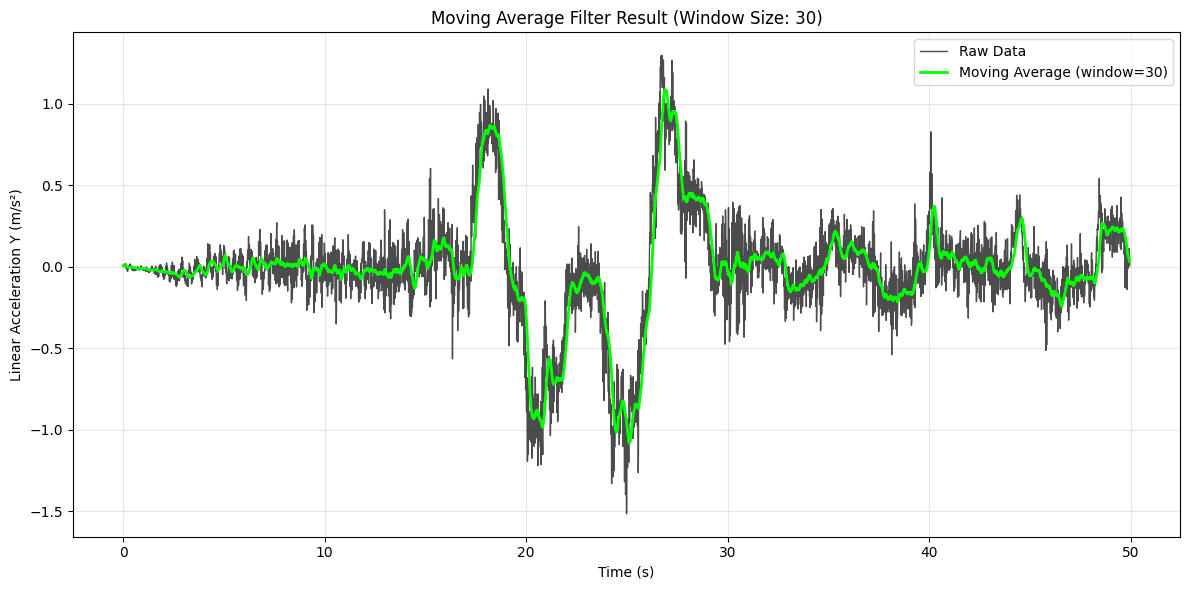

Moving Average Filter 결과 (window_size=30):
  - 평균: -0.0137 m/s²
  - 표준편차: 0.3148 m/s²
  - 노이즈 감소율: 6.7%


In [7]:
### 2. Moving Average Filter 적용

# 윈도우 크기 지정
window_size = 30  # 값을 바꿔가며 실험 진행

# Moving Average Filter 적용
ma_filtered = processor.moving_average_filter(linear_acceleration_y, window_size) # TODO: moving_average_filter 함수 완성

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(time_relative, linear_acceleration_y, 'k-', alpha=0.7, linewidth=1, label='Raw Data')
plt.plot(time_relative, ma_filtered, 'g-', linewidth=2, color='lime', label=f'Moving Average (window={window_size})')
plt.xlabel('Time (s)')
plt.ylabel('Linear Acceleration Y (m/s²)')
plt.title(f'Moving Average Filter Result (Window Size: {window_size})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Moving Average Filter 결과 (window_size={window_size}):")
print(f"  - 평균: {np.mean(ma_filtered):.4f} m/s²")
print(f"  - 표준편차: {np.std(ma_filtered):.4f} m/s²")
print(f"  - 노이즈 감소율: {(1 - np.std(ma_filtered)/np.std(linear_acceleration_y))*100:.1f}%")


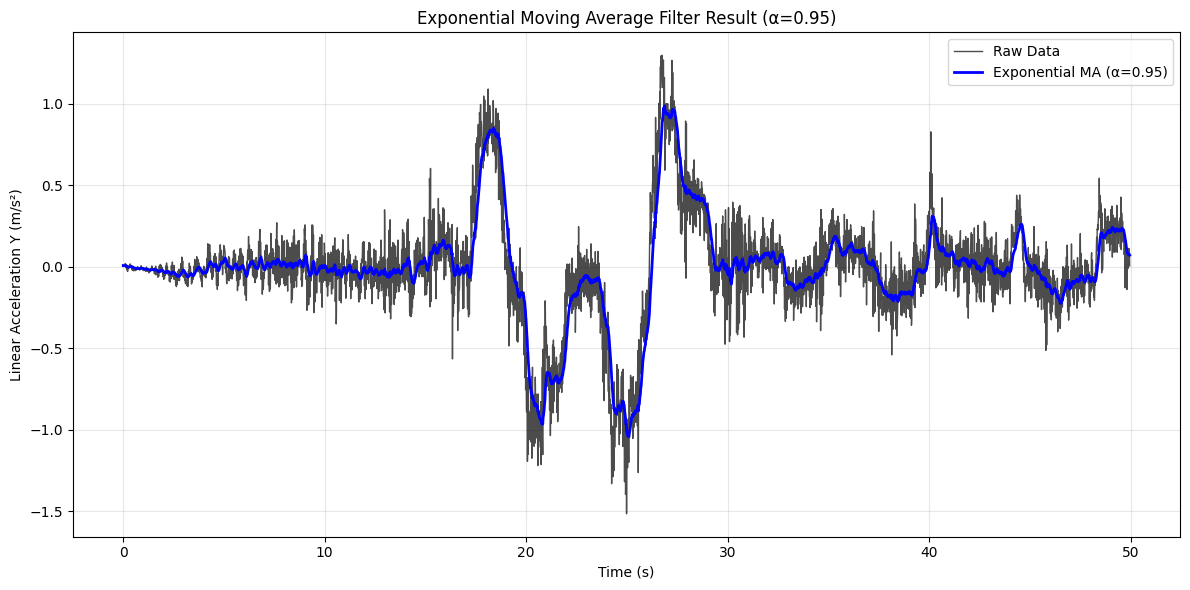

Exponential Moving Average Filter 결과 (α=0.95):
  - 평균: -0.0139 m/s²
  - 표준편차: 0.3063 m/s²
  - 노이즈 감소율: 9.2%


In [10]:
### 3. Exponential Moving Average Filter 적용

# 알파 값 지정
alpha = 0.95  # 값을 바꿔가며 실험 진행

# Exponential Moving Average Filter 적용
ema_filtered = processor.exponential_moving_average_filter(linear_acceleration_y, alpha) # TODO: exponential_moving_average_filter 함수 완성

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(time_relative, linear_acceleration_y, 'k-', alpha=0.7, linewidth=1, label='Raw Data')
plt.plot(time_relative, ema_filtered, 'b-', linewidth=2, label=f'Exponential MA (α={alpha})')
plt.xlabel('Time (s)')
plt.ylabel('Linear Acceleration Y (m/s²)')
plt.title(f'Exponential Moving Average Filter Result (α={alpha})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Exponential Moving Average Filter 결과 (α={alpha}):")
print(f"  - 평균: {np.mean(ema_filtered):.4f} m/s²")
print(f"  - 표준편차: {np.std(ema_filtered):.4f} m/s²")
print(f"  - 노이즈 감소율: {(1 - np.std(ema_filtered)/np.std(linear_acceleration_y))*100:.1f}%")


In [ ]:
### 4. 모든 필터링 결과 비교

# 모든 필터링 결과를 한 번에 비교
processor.plot_filtering_comparison(
    time_relative, linear_acceleration_y, 
    avg_filtered, ma_filtered, ema_filtered,
    title=f"Filtering Comparison (Window={window_size}, α={alpha})"
)


## 3. 휠 엔코더 시뮬레이션 및 속도 추정

휠 엔코더는 차량의 바퀴 회전을 감지하여 속도를 측정하는 센서입니다.  
이번 실습에서는 GT(Ground Truth) 속도 데이터를 생성하고, 이를 바탕으로 펄스 데이터를 만든 후,  
다시 펄스 데이터로부터 속도를 추정하는 두 가지 방법을 학습합니다.

### 펄스 생성 과정
1. **GT 속도 생성**: 사인파 형태의 연속적인 속도 신호
2. **위치 계산**: 속도를 적분하여 이동 거리 계산
3. **휠 각도 계산**: 이동 거리를 휠 반지름으로 나누어 회전각 계산
4. **펄스 생성**: 디지털 신호 (0 또는 1)로 변환

### 두 가지 속도 추정 방법
1. **Pulse Counting Method (M-Method)**: 일정 시간 동안의 펄스 개수로 속도 추정
2. **Pulse Timing Method (T-Method)**: 펄스 간 시간 간격으로 속도 추정

### 수식
**공통 각속도 계산:**
휠 엔코더로부터 각속도를 계산하는 수식:
```
ω = 2π × N / (Z × ΔT)
```
- ω: 각속도 (rad/s)
- N: 샘플링 주기 동안의 펄스 수
- Z: 회전당 펄스 수 (pulses per revolution)
- ΔT: 샘플링 주기 (sec)

**M-Method**: N = 펄스 개수, ΔT = 고정 시간 간격  

<img src="../resources/ch2/pulse_counting_method.png" width="50%">  

**T-Method**: N = 1, ΔT = 펄스 간 시간 간격  

<img src="../resources/ch2/pulse_timing_method.png" width="50%">  

**선속도 계산:**
```
v = ω × r
```
- v: 선속도 (m/s)
- r: 휠 반지름 (m)

In [11]:
### 1. 휠 엔코더 시뮬레이션 데이터 생성

# 시뮬레이션 파라미터 설정
duration = 10.0  # 시뮬레이션 시간 (초)
time_interval = 0.001  # 샘플링 간격 (초) - 고해상도
wheel_radius = 0.6  # 휠 반지름 (미터)
pulses_per_revolution = 20  # 회전당 펄스 수

print("=== 휠 엔코더 시뮬레이션 파라미터 ===")
print(f"시뮬레이션 시간: {duration} 초")
print(f"샘플링 간격: {time_interval} 초")
print(f"휠 반지름: {wheel_radius} m")
print(f"회전당 펄스 수: {pulses_per_revolution} 개")

# 시뮬레이션 데이터 생성
sim_data = processor.generate_wheel_encoder_simulation(
    duration=duration,
    time_interval=time_interval,
    wheel_radius=wheel_radius,
    pulses_per_revolution=pulses_per_revolution
)

print(f"\n✓ 시뮬레이션 데이터 생성 완료")
print(f"생성된 데이터 포인트 수: {len(sim_data['time'])}개")
print(f"속도 범위: {np.min(sim_data['gt_velocity']):.1f} ~ {np.max(sim_data['gt_velocity']):.1f} m/s")
print(f"펄스 값: 0 또는 1 (디지털 신호)")
print(f"사인파 주파수: 0.05 Hz")


=== 휠 엔코더 시뮬레이션 파라미터 ===
시뮬레이션 시간: 10.0 초
샘플링 간격: 0.001 초
휠 반지름: 0.6 m
회전당 펄스 수: 20 개

✓ 시뮬레이션 데이터 생성 완료
생성된 데이터 포인트 수: 10000개
속도 범위: 0.0 ~ 20.0 m/s
펄스 값: 0 또는 1 (디지털 신호)
사인파 주파수: 0.05 Hz


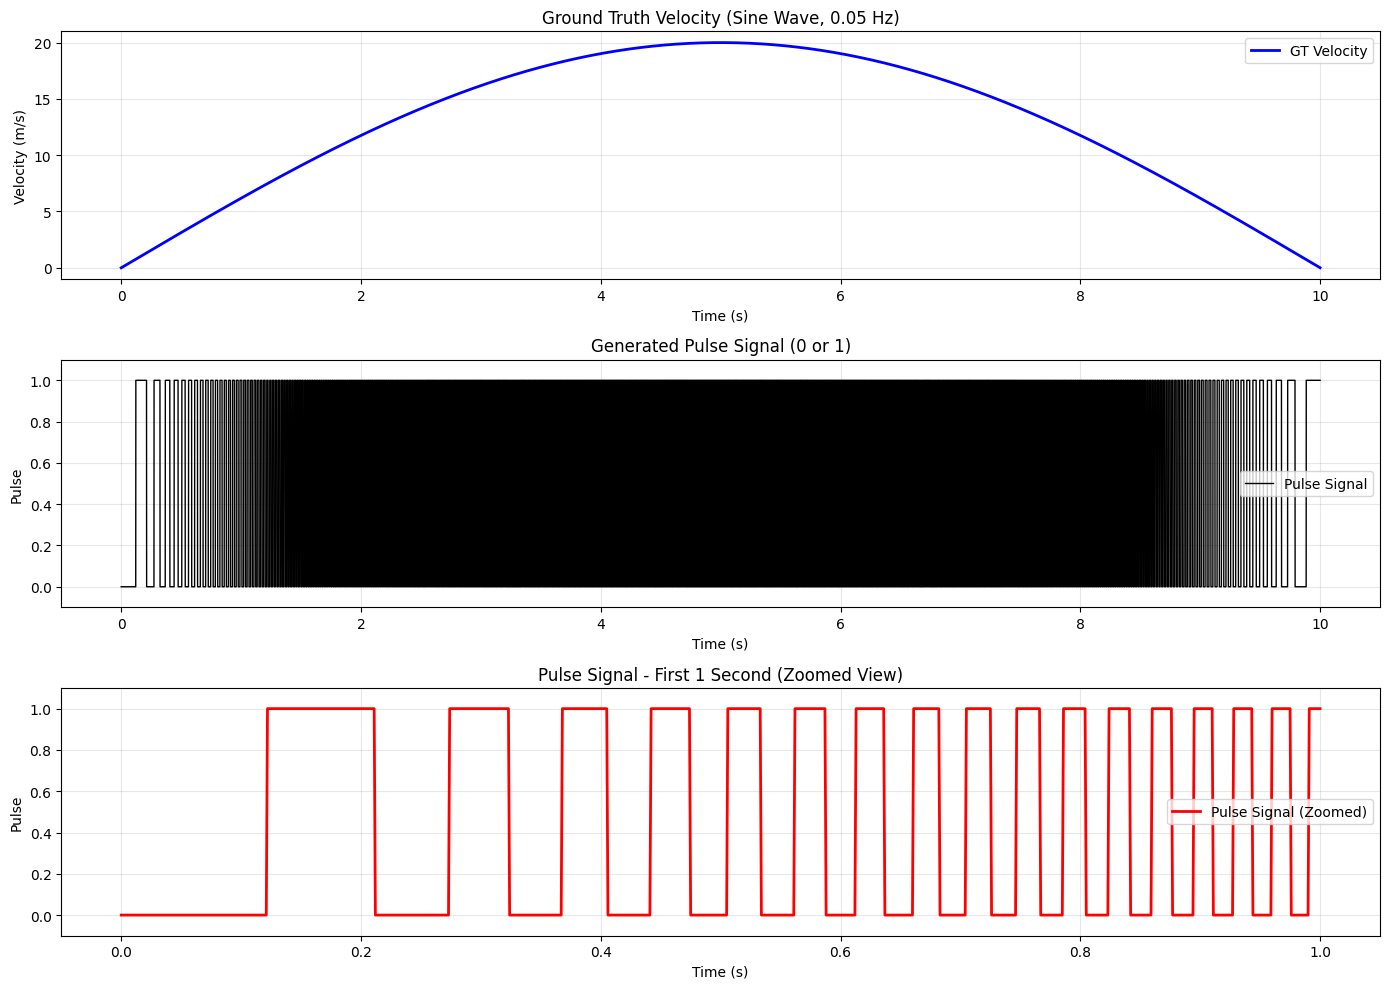

GT 데이터 특성:
평균 속도: 12.73 m/s
최대 속도: 20.00 m/s
최소 속도: 0.00 m/s
총 펄스 전환 횟수: 1351회


In [12]:
### 2. GT 속도 및 펄스 데이터 시각화

# GT 속도 시각화
plt.figure(figsize=(14, 10))

# GT 속도
plt.subplot(3, 1, 1)
plt.plot(sim_data['time'], sim_data['gt_velocity'], 'b-', linewidth=2, label='GT Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Ground Truth Velocity (Sine Wave, 0.05 Hz)')
plt.legend()
plt.grid(True, alpha=0.3)

# 펄스 데이터 (전체)
plt.subplot(3, 1, 2)
plt.plot(sim_data['time'], sim_data['pulses'], 'k-', linewidth=1, label='Pulse Signal')
plt.xlabel('Time (s)')
plt.ylabel('Pulse')
plt.title('Generated Pulse Signal (0 or 1)')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)

# 펄스 데이터 (확대, 처음 1초)
plt.subplot(3, 1, 3)
mask = sim_data['time'] <= 1.0
plt.plot(sim_data['time'][mask], sim_data['pulses'][mask], 'r-', linewidth=2, label='Pulse Signal (Zoomed)')
plt.xlabel('Time (s)')
plt.ylabel('Pulse')
plt.title('Pulse Signal - First 1 Second (Zoomed View)')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("GT 데이터 특성:")
print(f"평균 속도: {np.mean(sim_data['gt_velocity']):.2f} m/s")
print(f"최대 속도: {np.max(sim_data['gt_velocity']):.2f} m/s")
print(f"최소 속도: {np.min(sim_data['gt_velocity']):.2f} m/s")
print(f"총 펄스 전환 횟수: {np.sum(np.diff(sim_data['pulses']) != 0)}회")


=== Pulse Counting Method (M-Method) ===
카운팅 시간 간격: 0.15 초
✓ M-Method 속도 추정 완료
추정된 속도 범위: 0.00 ~ 20.11 m/s


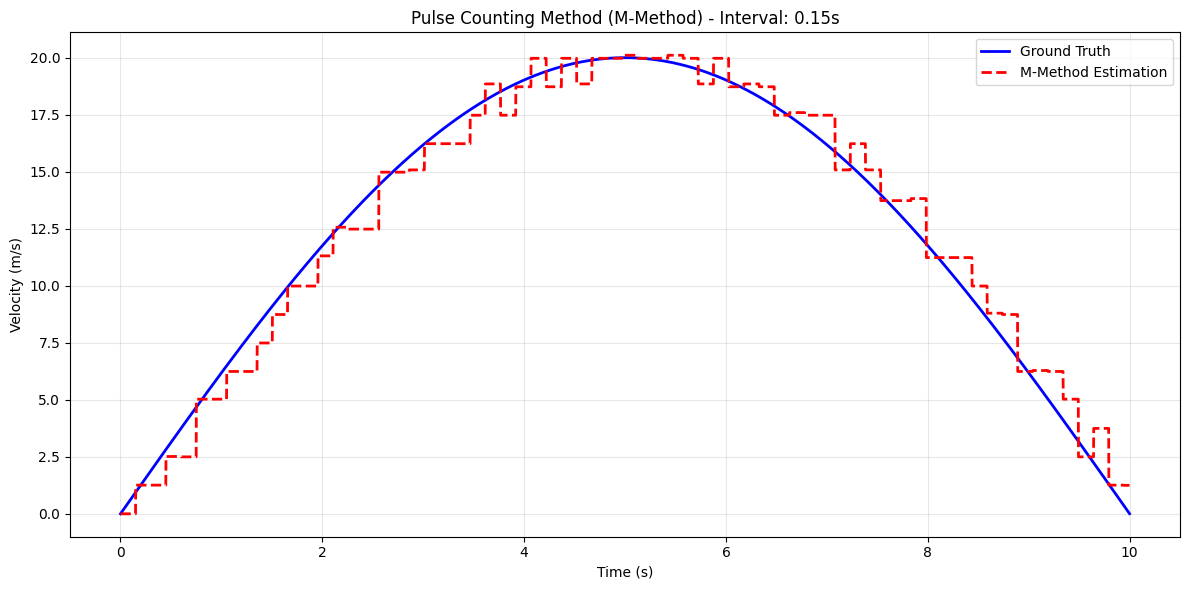

In [13]:
### 3. Pulse Counting Method (M-Method) 적용

# 파라미터 설정
counting_time_interval = 0.15  # seconds (변경 가능)

print(f"=== Pulse Counting Method (M-Method) ===")
print(f"카운팅 시간 간격: {counting_time_interval} 초")

# 각속도 추정
angular_velocity_m_method = processor.pulse_counting_method(
    sim_data['time'], sim_data['pulses'], 
    sim_data['pulses_per_revolution'], counting_time_interval
) # TODO: pulse_counting_method 함수 완성

# 선속도 계산
estimated_velocity_m_method = angular_velocity_m_method * sim_data['wheel_radius']

print(f"✓ M-Method 속도 추정 완료")
print(f"추정된 속도 범위: {np.min(estimated_velocity_m_method):.2f} ~ {np.max(estimated_velocity_m_method):.2f} m/s")

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sim_data['time'], sim_data['gt_velocity'], 'b-', linewidth=2, label='Ground Truth')
plt.plot(sim_data['time'], estimated_velocity_m_method, 'r--', linewidth=2, label='M-Method Estimation')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title(f'Pulse Counting Method (M-Method) - Interval: {counting_time_interval}s')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== Pulse Timing Method (T-Method) ===
✓ T-Method 속도 추정 완료
추정된 속도 범위: 0.00 ~ 20.94 m/s


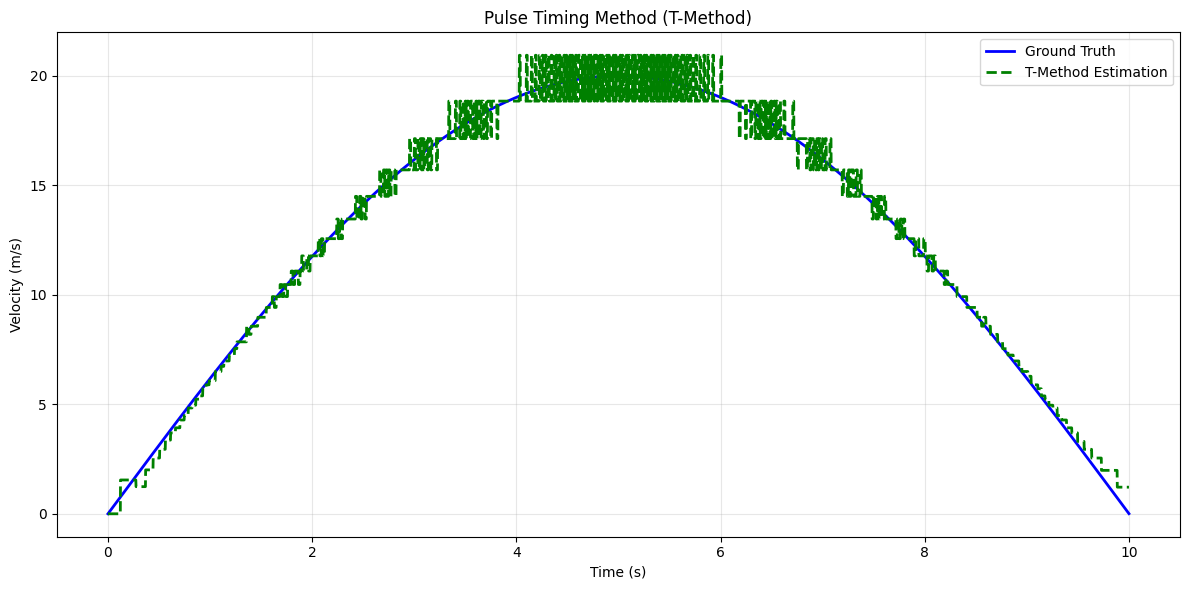

In [14]:
### 4. Pulse Timing Method (T-Method) 적용

print(f"=== Pulse Timing Method (T-Method) ===")

# 각속도 추정
angular_velocity_t_method = processor.pulse_timing_method(
    sim_data['time'], sim_data['pulses'], 
    sim_data['pulses_per_revolution']
) # TODO: pulse_timing_method 함수 완성

# 선속도 계산
estimated_velocity_t_method = angular_velocity_t_method * sim_data['wheel_radius']

print(f"✓ T-Method 속도 추정 완료")
print(f"추정된 속도 범위: {np.min(estimated_velocity_t_method):.2f} ~ {np.max(estimated_velocity_t_method):.2f} m/s")

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sim_data['time'], sim_data['gt_velocity'], 'b-', linewidth=2, label='Ground Truth')
plt.plot(sim_data['time'], estimated_velocity_t_method, 'g--', linewidth=2, label='T-Method Estimation')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Pulse Timing Method (T-Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


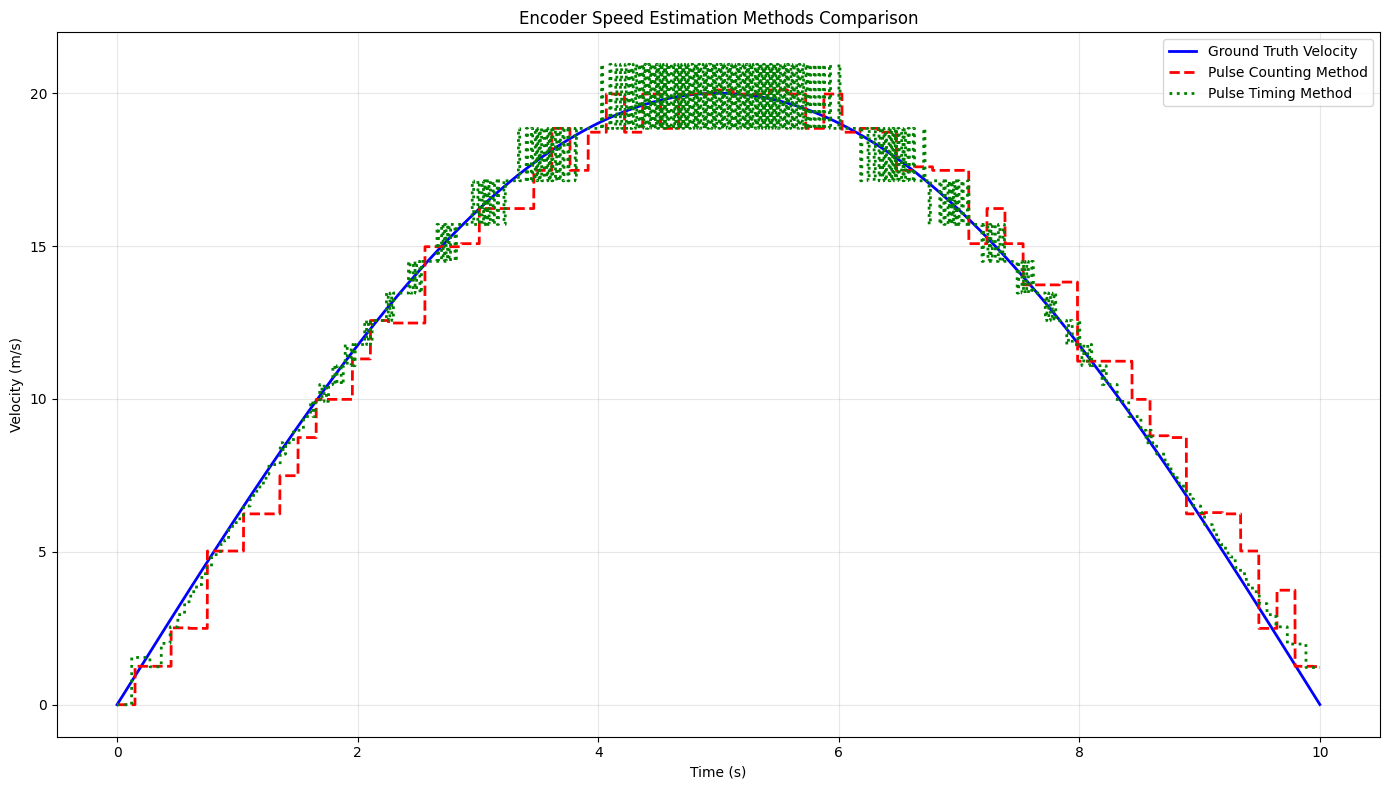

=== 두 방법 성능 비교 ===
Method               RMSE (m/s)   MAE (m/s)    Max Error (m/s)
-----------------------------------------------------------------
M-Method             0.8824       0.7137       2.4390         
T-Method             0.6144       0.4770       1.9423         

🎯 방법별 특징:
• M-Method (Pulse Counting):
  - 일정 시간 동안 펄스 개수 측정
  - 낮은 속도에서 더 정확
  - 시간 지연이 있음
  - 노이즈에 강함

• T-Method (Pulse Timing):
  - 펄스 간 시간 간격 측정
  - 높은 속도에서 더 정확
  - 실시간 응답성 좋음
  - 낮은 속도에서 불안정할 수 있음


In [15]:
### 5. 두 방법 비교 및 성능 분석

# 통합 비교 시각화
processor.plot_encoder_speed_comparison(
    sim_data['time'], sim_data['gt_velocity'],
    estimated_velocity_m_method, estimated_velocity_t_method,
    title="Encoder Speed Estimation Methods Comparison"
)

# 성능 분석
# M-Method 오차 계산
error_m_method = estimated_velocity_m_method - sim_data['gt_velocity']
rmse_m = np.sqrt(np.mean(error_m_method**2))
mae_m = np.mean(np.abs(error_m_method))

# T-Method 오차 계산  
error_t_method = estimated_velocity_t_method - sim_data['gt_velocity']
rmse_t = np.sqrt(np.mean(error_t_method**2))
mae_t = np.mean(np.abs(error_t_method))

print("=== 두 방법 성능 비교 ===")
print(f"{'Method':<20} {'RMSE (m/s)':<12} {'MAE (m/s)':<12} {'Max Error (m/s)':<15}")
print("-" * 65)
print(f"{'M-Method':<20} {rmse_m:<12.4f} {mae_m:<12.4f} {np.max(np.abs(error_m_method)):<15.4f}")
print(f"{'T-Method':<20} {rmse_t:<12.4f} {mae_t:<12.4f} {np.max(np.abs(error_t_method)):<15.4f}")

print("\n🎯 방법별 특징:")
print("• M-Method (Pulse Counting):")
print("  - 일정 시간 동안 펄스 개수 측정")
print("  - 낮은 속도에서 더 정확")
print("  - 시간 지연이 있음")
print("  - 노이즈에 강함")
print("\n• T-Method (Pulse Timing):")
print("  - 펄스 간 시간 간격 측정")
print("  - 높은 속도에서 더 정확")
print("  - 실시간 응답성 좋음")
print("  - 낮은 속도에서 불안정할 수 있음")

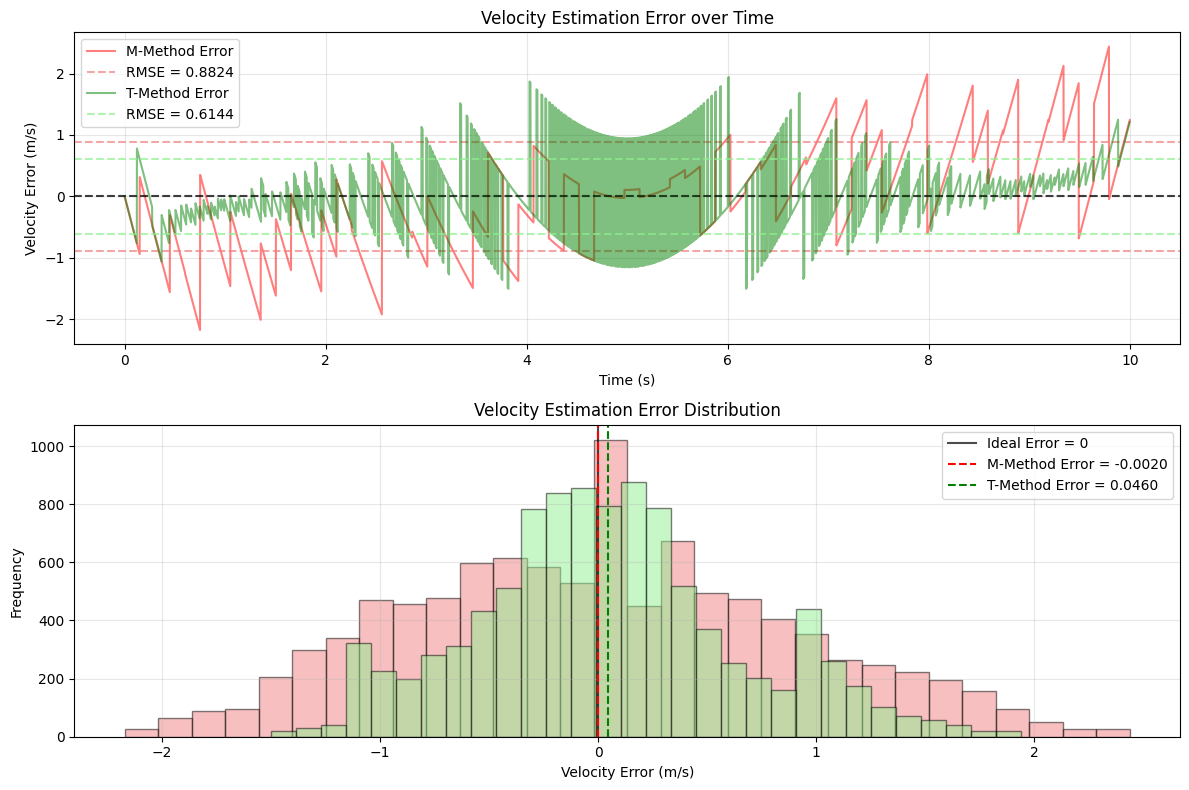

=== 오차 통계 ===
오차 평균: 0.045971 m/s
오차 표준편차: 0.612635 m/s
오차 최댓값: 1.942331 m/s
오차 최솟값: -1.500906 m/s


In [16]:
### 6. 오차 분석 및 시각화

# 오차 시각화
plt.figure(figsize=(12, 8))

# 서브플롯 1: 시간에 따른 오차
plt.subplot(2, 1, 1)
# error_m_method
plt.plot(sim_data['time'], error_m_method, 'r-', linewidth=1.5, label='M-Method Error', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=rmse_m, color='lightcoral', linestyle='--', alpha=0.7, label=f'RMSE = {rmse_m:.4f}')
plt.axhline(y=-rmse_m, color='lightcoral', linestyle='--', alpha=0.7)
# error_t_method
plt.plot(sim_data['time'], error_t_method, 'g-', linewidth=1.5, label='T-Method Error', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=rmse_t, color='lightgreen', linestyle='--', alpha=0.7, label=f'RMSE = {rmse_t:.4f}')
plt.axhline(y=-rmse_t, color='lightgreen', linestyle='--', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Velocity Error (m/s)')
plt.title('Velocity Estimation Error over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# 서브플롯 2: 오차 히스토그램
plt.subplot(2, 1, 2)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.7, label='Ideal Error = 0')
# error_m_method
plt.hist(error_m_method, bins=30, alpha=0.5, color='lightcoral', edgecolor='black')
plt.axvline(x=np.mean(error_m_method), color='red', linestyle='--', 
           label=f'M-Method Error = {np.mean(error_m_method):.4f}')
# error_t_method
plt.hist(error_t_method, bins=30, alpha=0.5, color='lightgreen', edgecolor='black')
plt.axvline(x=np.mean(error_t_method), color='green', linestyle='--', 
           label=f'T-Method Error = {np.mean(error_t_method):.4f}')
plt.xlabel('Velocity Error (m/s)')
plt.ylabel('Frequency')
plt.title('Velocity Estimation Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== 오차 통계 ===")
print(f"오차 평균: {np.mean(error_t_method):.6f} m/s")
print(f"오차 표준편차: {np.std(error_t_method):.6f} m/s")
print(f"오차 최댓값: {np.max(error_t_method):.6f} m/s")
print(f"오차 최솟값: {np.min(error_t_method):.6f} m/s")


## 실습 요약 및 결론

### 🎯 실습에서 배운 내용

1. **차량 모션 센서 데이터 분석**
   - ROS bag 파일에서 IMU 데이터 로딩
   - 차량 궤적과 함께 시간에 따른 각속도 및 선형가속도 변화 관찰

2. **노이즈 필터링 기법**
   - **Average Filter**: 단순하지만 시간 정보 손실
   - **Moving Average Filter**: 지역적 특성 보존, 윈도우 크기 조정 가능
   - **Exponential Moving Average**: 실시간 처리 적합, α 값으로 반응성 조절

3. **휠 엔코더 시뮬레이션**
   - 정밀한 펄스 데이터 생성 (디지털 신호)
   - **M-Method (Pulse Counting)**: 펄스 개수 기반 속도 추정
   - **T-Method (Pulse Timing)**: 펄스 간격 기반 속도 추정
   - 두 방법의 특성 및 성능 비교 (RMSE, 평균, histogram)